In [1]:
pip install tensorflow-metal

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.15.0
GPU available: True


In [3]:
import os

In [4]:
X_train = np.load('data/embeddings/train_embeddings.npy')
X_val = np.load('data/embeddings/val_embeddings.npy')
X_test = np.load('data/embeddings/test_embeddings.npy')

y_train = np.load('data/processed/y_train.npy')
y_val = np.load('data/processed/y_val.npy')
y_test = np.load('data/processed/y_test.npy')

with open('data/processed/class_weights.pkl', 'rb') as f:
    class_weight_dict = pickle.load(f)

In [5]:
# MLP Model
def build_mlp():
    model = keras.Sequential([
        layers.Input(shape=(384,)),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(3, activation='softmax')
    ], name='MLP_Baseline')
    
    return model

mlp_model = build_mlp()
mlp_model.summary()

2025-12-10 20:19:20.446543: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-10 20:19:20.446785: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-10 20:19:20.447918: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-10 20:19:20.448769: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-10 20:19:20.449109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "MLP_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               98560     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [6]:
# Compile Model
mlp_model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
# Callbacks
Path('models').mkdir(exist_ok=True)

callback_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'models/mlp_best.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]


In [8]:
# Train Model
history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callback_list,
    verbose=1
)

Epoch 1/50


2025-12-10 20:19:21.693583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - 66s 26ms/step - loss: 0.8691 - accuracy: 0.6547 - val_loss: 0.7233 - val_accuracy: 0.6857 - lr: 0.0010
Epoch 2/50
2500/2500 [==============================] - 37s 15ms/step - loss: 0.8068 - accuracy: 0.6906 - val_loss: 0.6649 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 3/50
2500/2500 [==============================] - 32s 13ms/step - loss: 0.8058 - accuracy: 0.6943 - val_loss: 0.7056 - val_accuracy: 0.7171 - lr: 0.0010
Epoch 4/50
2500/2500 [==============================] - 32s 13ms/step - loss: 0.8046 - accuracy: 0.6974 - val_loss: 0.7271 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 5/50
2500/2500 [==============================] - 33s 13ms/step - loss: 0.8057 - accuracy: 0.6965 - val_loss: 0.7516 - val_accuracy: 0.6712 - lr: 0.0010
Epoch 6/50
2500/2500 [==============================] - 34s 13ms/step - loss: 0.8037 - accuracy: 0.6964 - val_loss: 0.6883 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 7/50
2500/2500 [==============================] - E

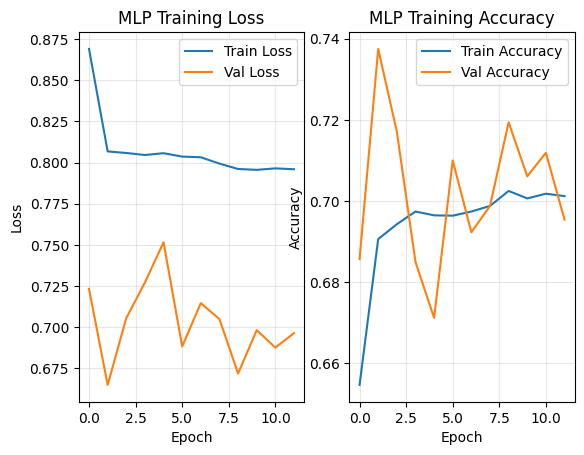

  Train Loss: 0.7960
  Train Acc:  0.7012
  Val Loss:   0.6964
  Val Acc:    0.6954


In [9]:
fig, axes = plt.subplots(1, 2)

# Loss curves
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('MLP Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy curves
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('MLP Training Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.savefig('results/figures/mlp_training_curves.png')
plt.show()

print(f"  Train Loss: {history.history['loss'][-1]:.4f}")
print(f"  Train Acc:  {history.history['accuracy'][-1]:.4f}")
print(f"  Val Loss:   {history.history['val_loss'][-1]:.4f}")
print(f"  Val Acc:    {history.history['val_accuracy'][-1]:.4f}")

In [10]:
test_loss, test_acc = mlp_model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Predictions
y_pred_probs = mlp_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import f1_score
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Macro F1
print(f"Macro F1-Score: {macro_f1:.4f} ({macro_f1*100:.2f}%)")

Test Loss:     0.6684
Test Accuracy: 0.7392 (73.92%)
Macro F1-Score: 0.5785 (57.85%)


In [11]:
# Classification Report
class_names = ['Negative', 'Neutral', 'Positive']

print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    Negative     0.5172    0.7081    0.5978      1463
     Neutral     0.2126    0.4234    0.2831       829
    Positive     0.9463    0.7791    0.8546      7708

    accuracy                         0.7392     10000
   macro avg     0.5587    0.6369    0.5785     10000
weighted avg     0.8227    0.7392    0.7696     10000



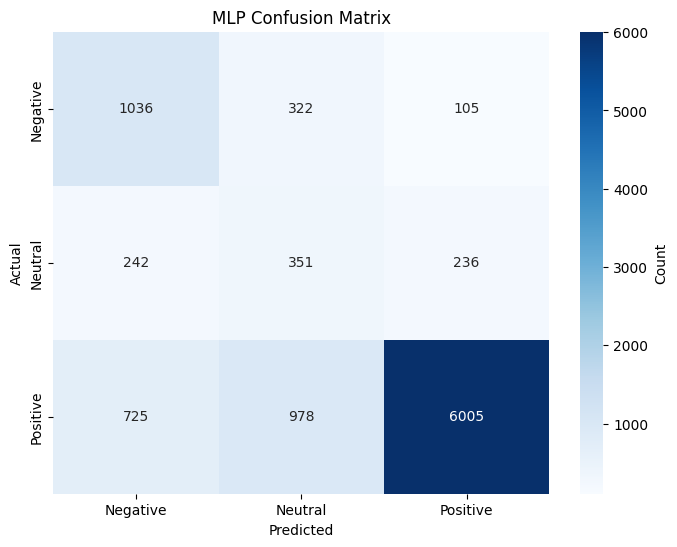

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
ax.set_title('MLP Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.savefig('results/figures/mlp_confusion_matrix.png')
plt.show()

   Class  Precision   Recall  F1-Score  Support
Negative   0.517224 0.708134  0.597807     1463
 Neutral   0.212598 0.423402  0.283065      829
Positive   0.946265 0.779061  0.854561     7708


/var/folders/sl/hvvwjftn2r1bjbl01xd6_f040000gn/T/ipykernel_74629/2112341992.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


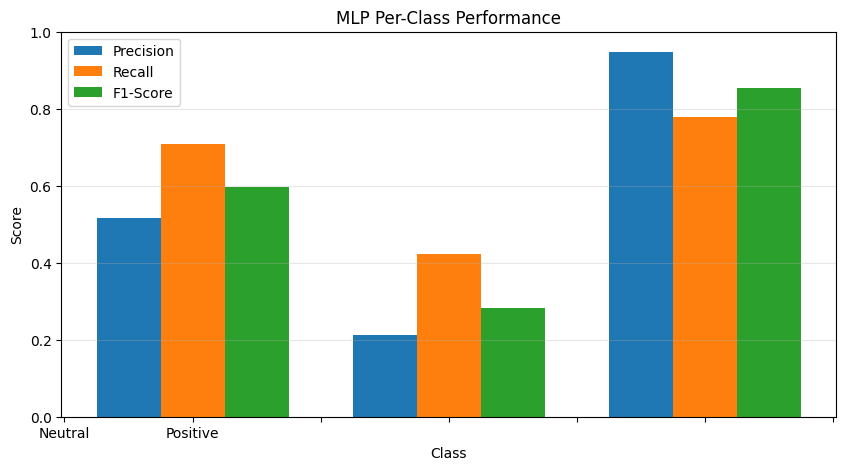

In [13]:
# Per-Class Performance
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

perf_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print(perf_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(class_names))
width = 0.25

ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1-Score')

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('MLP Per-Class Performance')
ax.set_xticklabels(class_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.savefig('results/figures/mlp_per_class_performance.png')
plt.show()

In [14]:
# Find misclassified examples
errors = y_test != y_pred
error_indices = np.where(errors)[0]

print(f"Total errors: {len(error_indices)} / {len(y_test)} ({len(error_indices)/len(y_test)*100:.2f}%)")

# Count errors by true class
for i, class_name in enumerate(class_names):
    class_mask = y_test == i
    class_errors = np.sum(errors & class_mask)
    class_total = np.sum(class_mask)
    print(f"  {class_name}: {class_errors}/{class_total} ({class_errors/class_total*100:.1f}%)")

Total errors: 2608 / 10000 (26.08%)
  Negative: 427/1463 (29.2%)
  Neutral: 478/829 (57.7%)
  Positive: 1703/7708 (22.1%)


## Save Results

In [15]:
results = {
    'model': 'MLP',
    'test_accuracy': float(test_acc),
    'test_macro_f1': float(macro_f1),  
    'test_loss': float(test_loss),
    'precision': precision.tolist(),
    'recall': recall.tolist(),
    'f1': f1.tolist(),
    'confusion_matrix': cm.tolist(),
    'epochs_trained': len(history.history['loss']),
    'parameters': mlp_model.count_params()
}

import json
with open('results/metrics/mlp_results.json', 'w') as f:
    json.dump(results, f, indent=2)

# Save predictions
np.save('results/metrics/mlp_predictions.npy', y_pred)
np.save('results/metrics/mlp_probabilities.npy', y_pred_probs)